In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"

import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
from nrmifactors import algorithm as algo
from nrmifactors.state import State
import nrmifactors.priors as priors

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

/opt/homebrew/Caskroom/miniconda/base/envs/scipy-dev/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import logging
logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()

logger.addFilter(CheckTypesFilter())

In [3]:
ndata = 500

key = random.PRNGKey(0)

means = np.array([-10.0, -3.0, 3.0, 10.0])

probas = np.vstack(
    [np.ones(4),
     np.array([0, 1, 0, 1]),
     np.array([1, 0, 1, 0]),
     np.array([0, 0, 1, 1]),
     np.array([1, 1, 0, 0]),
     np.array([0, 0.2, 0, 0.8]),
     np.array([0.7, 0.3, 0, 0])]
)

probas = np.vstack(
    [np.ones(4),
     np.array([0.0, 1.0, 0.0, 1.0]),
     np.array([1.0, 0.0, 1.0, 0.0]),
     np.array([0.0, 0.1, 0.0, 0.9]),
     np.array([0.9, 0.0, 0.1, 0.0]),
     np.array([1.0, 0.0, 0.0, 0.0])
    ]
)

ngroups = probas.shape[0]

probas = probas / probas.sum(axis=1)[:, np.newaxis]

key, subkey = random.split(key)
clus = tfd.Categorical(probs=probas).sample((ndata), seed=subkey).T
data = tfd.Normal(means[clus], np.ones_like(clus, dtype=float)).sample(seed=subkey)

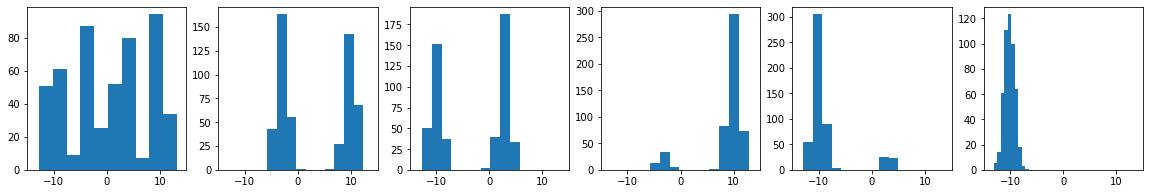

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 3))
for i in range(ngroups):
    axes[i].hist(onp.array(data[i, :]))
    axes[i].set_xlim(-15, 15)

In [5]:
from sklearn.cluster import KMeans

natoms = 10
nlat = 20

# initialize stuff
# init_atoms = np.hstack([
#    tfd.Normal(loc=0, scale=10).sample(natoms, seed=key).reshape(-1, 1),
#    np.ones((natoms, 1))
# ])

km = KMeans(natoms)
km.fit(data.reshape(-1, 1))
clus = km.predict(data.reshape(-1,1)).reshape(data.shape)
means = km.cluster_centers_

init_atoms = np.hstack([means, np.ones_like(means) * 0.3])

In [6]:
init_atoms

DeviceArray([[  9.88550883,   0.3       ],
             [ -8.67499523,   0.3       ],
             [  2.38616245,   0.3       ],
             [ -3.78334141,   0.3       ],
             [ -9.9111409 ,   0.3       ],
             [-11.09310491,   0.3       ],
             [ 11.1091825 ,   0.3       ],
             [  8.62930994,   0.3       ],
             [  3.85208849,   0.3       ],
             [ -2.11925041,   0.3       ]], dtype=float64)

In [19]:
#init_atoms = np.hstack([means.reshape(-1, 1), np.ones_like(means).reshape(-1, 1) * 1])
#natoms = init_atoms.shape[0]

prior = priors.NrmiFacPrior(
    kern_prior=priors.NNIGPrior(0.0, 0.01, 5.0, 5.0),
    lam_prior_iid=priors.GammaPrior(2.0, 2.0),
    lam_prior_mgp=priors.MGPPrior(50.0, 2.0, 3.0, 0, -0.05, 0.05),
    lam_prior="mgp",
    m_prior=priors.GammaPrior(2.0, 2.0),
    j_prior=priors.GammaPrior(2.0, 2.0)
)


lam = np.ones((ngroups, nlat)) / nlat
#m = np.hstack([np.eye(nlat) * 5 + 0.5, np.zeros((nlat, natoms - nlat)) + 0.5])
m = tfd.Gamma(prior.m_prior.a, prior.m_prior.b).sample((nlat, natoms), seed=key).astype(float)


j = np.ones(natoms).astype(float) * 0.5
u = np.ones(ngroups).astype(float)

#clus = tfd.Categorical(probs=np.ones(natoms)/natoms).sample(data.shape, seed=key)
state = State(
    iter=0,
    atoms=init_atoms, 
    j=j, 
    lam=lam,
    phis=1.0/lam,
    deltas=np.ones(lam.shape[1]),
    m=m, 
    clus=clus, 
    u=u,
)
nan_idx = np.where(np.isnan(data))
nobs_by_group = np.array(
        [np.count_nonzero(~np.isnan(x)) for x in data]).astype(float)

In [20]:
key = random.PRNGKey(202204)

In [21]:
state, key = algo.adapt_mgp(state, 1000, 50, data, nan_idx, nobs_by_group, prior, key)

50/1000 removing col, snew shape:  (6, 16)
100/1000 removing col, snew shape:  (6, 12)
150/1000 removing col, snew shape:  (6, 10)
200/1000 removing col, snew shape:  (6, 9)
250/1000 adding column
300/1000 removing col, snew shape:  (6, 9)
350/1000 removing col, snew shape:  (6, 7)
400/1000 adding column
450/1000 adding column
500/1000 removing col, snew shape:  (6, 7)
550/1000 adding column
600/1000 removing col, snew shape:  (6, 7)
650/1000 adding column
700/1000 removing col, snew shape:  (6, 7)
750/1000 adding column
800/1000 removing col, snew shape:  (6, 7)
850/1000 removing col, snew shape:  (6, 6)
900/1000 adding column
950/1000 removing col, snew shape:  (6, 6)
1000/1000 removing col, snew shape:  (6, 5)


In [22]:
tmp = np.copy(state.m)
state.m = np.zeros_like(state.m) + 0.1
for l in range(m.shape[1]):
    print(l, np.argmax(tmp, axis=1)[l])
    state.m = state.m.at[l, np.argmax(tmp, axis=1)[l]].set(5.0)
    
state.m

0 7
1 1
2 3
3 9
4 8
5 8
6 8
7 8
8 8
9 8


DeviceArray([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 5. , 0.1, 0.1],
             [0.1, 5. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
             [0.1, 0.1, 0.1, 5. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
             [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 5. ],
             [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 5. , 0.1]],            dtype=float64)

In [23]:
from copy import deepcopy

niter = 10000
nburn = 5000
thin = 1


states = []

for i in range(niter):
    print("\r{0}/{1}".format(i+1, niter), flush=True, end=" ")
    state, key = algo.run_one_step(state, data, nan_idx, nobs_by_group, prior, key)
    if (i > nburn) and (i % thin == 0):
        states.append(deepcopy(state))

10000/10000          

In [ ]:
state.m

In [ ]:
import pickle


with open("simu1/chains_mgp2.pickle", "wb") as fp:
    pickle.dump(states, fp)

In [24]:
def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens

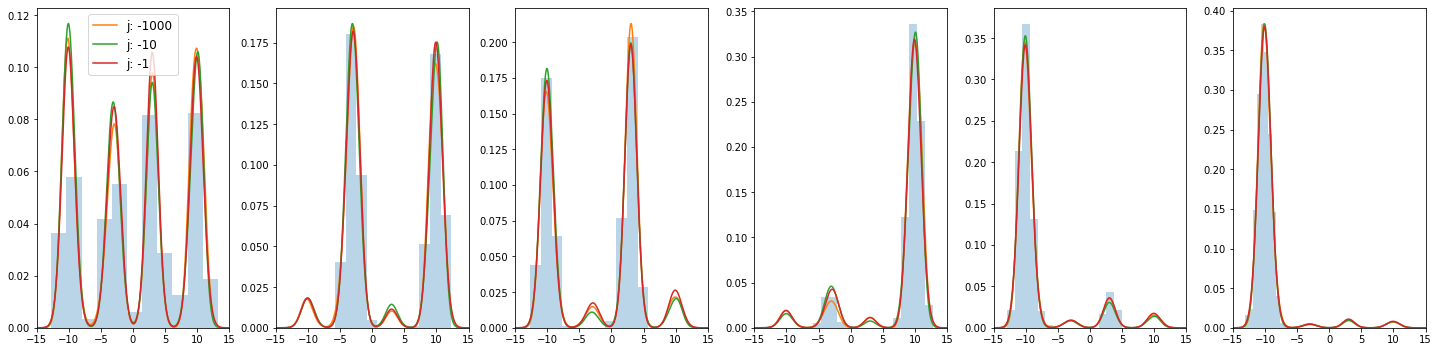

In [25]:
xgrid = np.linspace(-15, 15, 1000)

fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

idx = [-1, -10, -1000]

for i in range(ngroups):
    axes[i].hist(onp.array(data[i, :]), density=True, alpha=0.3, bins="doane")

for j in sorted(idx):

    state = states[j]
    dens = eval_densities(xgrid, state.lam, state.m, state.j, state.atoms)
    for i in range(ngroups):
        axes[i].plot(xgrid, dens[i, :], label="j: {0}".format(j))
        axes[i].set_xlim(-15, 15)
        
axes[0].legend(fontsize=12)   
plt.tight_layout()
# plt.savefig("simu1/dens_estimate.pdf", bbox_inches="tight")        
plt.show()

In [26]:
states[-1].m

array([[3.11244047e+00, 3.26477727e-02, 2.03311921e-02, 3.04120701e-01,
        1.43606745e-02, 4.74263374e-02, 1.88425980e+00, 3.08768114e+00,
        3.14554915e-02, 6.41534151e-01],
       [5.44623202e-02, 8.10488514e+00, 8.71308113e-02, 5.15504133e-02,
        3.67684182e+00, 4.36084552e+00, 1.77133547e-02, 6.10509893e-02,
        1.88005086e-01, 6.50882647e-03],
       [2.08228142e-01, 1.14559831e-01, 7.76496293e-01, 4.53368813e-01,
        7.77051079e-01, 1.25986098e+00, 1.96846663e-01, 4.38855691e-01,
        3.48855573e-01, 1.05253982e+00],
       [1.97829909e+00, 3.39398448e-02, 1.14328769e-02, 2.24275751e+00,
        5.78504332e-03, 1.54237876e-02, 1.46738268e+00, 1.87107665e+00,
        7.07110897e-02, 3.45247381e+00],
       [1.12448559e-01, 3.19603779e-01, 3.74090053e+00, 7.90142700e-03,
        7.80563939e-02, 3.41258152e-01, 7.00718759e-02, 2.23096635e-01,
        5.77202025e+00, 2.32669080e-01]])

In [27]:
states[-1].lam

array([[  7.95841853,   6.59124641,   2.27565204,  32.96097827,
         15.68885979],
       [  7.69752427,   4.68260675,   3.09152852, 381.15002789,
          5.78909895],
       [  4.36340287,  17.86295976,   2.63835258,   8.45540732,
         49.67138087],
       [602.36621024,   4.49979652,   1.63082879,  15.9467652 ,
          7.70011858],
       [  5.94252329,  54.55307132,   1.98024292,   6.07089832,
         10.66669239],
       [  7.64075928, 197.05744051,   2.49757161,   9.08867386,
          6.32474368]])

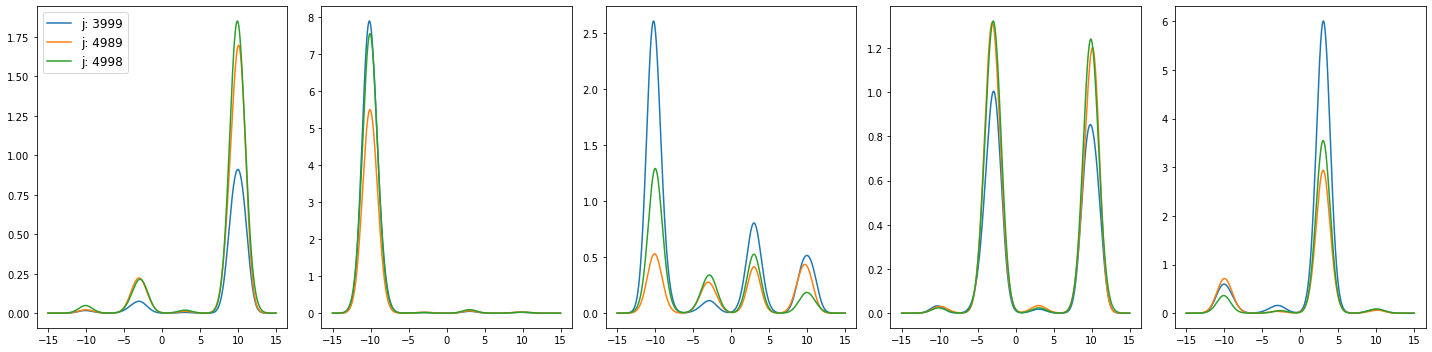

In [28]:
nlat = states[-1].lam.shape[1]

fig, axes = plt.subplots(nrows=1, ncols=int(nlat), figsize=(20, 5))
axes = axes.flat

for j in sorted(idx):
    state = states[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], label="j: {0}".format(len(states) + j))
        
axes[0].legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
states[-1].lam[3, :]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(idx), figsize=(7, 3))

idx = sorted(idx)

lambs = np.array([states[i].lam for i in idx])
vmax = np.max(lambs)

for i in range(len(idx)):
    lam = states[idx[i]].lam
    im = axes[i].imshow(lam, vmax=vmax, vmin=-vmax, cmap="RdBu")
    axes[i].set_title("j: {0}".format(len(states) + idx[i]))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)    

# plt.savefig("simu1/lambdas.pdf", bbox_inches="tight")

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

def get_lambda_mgp(phis, deltas):
    taus = np.cumprod(deltas, axis=-1)
    out = 1.0 / (phis * taus)
    return out

for i in range(ngroups):
    for j in range(nlat):
        axes[i].plot([x.lam[i, j] for x in states[-500:]], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Lambda[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(20,5))

axes = axes.flat


for i in range(ngroups):
    for j in range(nlat):
        axes[j].plot([x.lam[i, j] for x in states[-1000:]], label="j: {0}".format(j + 1))
    

axes[0].legend(fontsize=12)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

for i in range(ngroups):
    for j in range(nlat):
        axes[i].plot([x.phis[i, j] for x in states[-1000:]], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Phi[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

In [ ]:
fig = plt.figure(figsize=(10, 5))

deltachain = np.stack([x.deltas for x in states[-1000:]])
tauchain = np.cumprod(deltachain, axis=-1)

for j in range(nlat):
    plt.plot(1.0 / tauchain[:, j], label="j: {0}".format(j + 1))

axes[0].legend(fontsize=12)

# PostProcess

In [ ]:
import pickle

with open("simu1/chains_mgp2.pickle", "rb") as fp:
    states = pickle.load(fp)

In [29]:
from jax import jit


M = states[-1].m
lam = states[-1].lam
J = states[-1].j
xgrid = np.linspace(-15, 15, 1000)

component_dens = np.array([
    tfd.Normal(x[0], np.sqrt(x[1])).prob(xgrid) for x in states[0].atoms])
delta = xgrid[1] - xgrid[0]


@jit
def obj_func(x):
    curr_m = x @ M
    trans_dens = curr_m * J @ component_dens
    trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)
    out = 0.0
    for i in range(trans_dens.shape[0]):
        for j in range(i):
            curr = (np.sum((trans_dens[i, :] * trans_dens[j, :]) **2 ) * delta)
            out += curr
    return out

@jit
def constraints(x):
    return - np.concatenate([
        (lam @ np.linalg.inv(x)).reshape(-1, 1),
        (x @ M).reshape(-1, 1)])[:, 0]

@jit
def max0(x):
    return x * (x > 0)

@jit
def penalty(x, lambdas):
    return 0.5 * 1.0 * np.sum(max0(lambdas / 0.5 + constraints(x))**2)

In [30]:
from jax import jacfwd, grad
from nrmifactors.postprocess import ralm

x0 = np.eye(M.shape[0])

grad_f = grad(obj_func)
f = obj_func
constr_eval = constraints(x0)
grad_cons = jacfwd(constraints)
stepsize = 1e-6
init_thr = 1e-2
target_thr = 1e-6
min_lambda = 1e-4
init_lambdas = np.zeros_like(constr_eval) + 1
max_lambda = 20
init_rho = 1
dmin = 1e-6

In [31]:
from nrmifactors.postprocess import dissipative_lie_rattle_fast

x0 = np.eye(M.shape[0])
opt_x, niter = dissipative_lie_rattle_fast(f, grad_f, x0, 0.9, 1e-6, 1e-6, maxiter=100000)
opt_x

DeviceArray([[ 9.99086758e-01,  1.63745818e-02,  5.33335815e-03,
               4.48970423e-03,  1.26583899e-02],
             [ 4.52546638e-03,  1.00294754e+00,  2.15091664e-03,
               5.85215117e-03,  7.60600341e-03],
             [ 1.50921161e-02, -3.60497722e-02,  9.97055470e-01,
               2.10944871e-02,  1.10924810e-02],
             [-5.48181152e-03,  1.67641710e-02,  4.45760350e-03,
               1.00099390e+00,  1.03718165e-02],
             [ 1.38074198e-03, -6.09334678e-03, -6.21523800e-04,
               2.19617602e-03,  1.00015904e+00]], dtype=float64)

In [32]:
mu = 0.1
init_lambdas = np.zeros_like(constr_eval) + 0.01
max_lambda = 1
init_rho = 1
opt_x = np.eye(M.shape[0])

opt_x_pen = ralm(
    obj_func, grad_f, constraints, grad_cons, opt_x, mu, stepsize, 
    init_thr, target_thr, init_lambdas, min_lambda, max_lambda, 
    init_rho, dmin, maxiter=100)

constraints(opt_x_pen)

Init Loss:  0.017859630116287467
Loss: 0.017469699615919907, step: 50.033983306935845, eps: 0.01
max(lambdas) :  0.0001
Loss: 0.017466275120506917, step: 0.003614657290807441, eps: 0.009000000000000001
max(lambdas) :  0.0001
Loss: 0.017462866522754788, step: 0.003602542210006508, eps: 0.008100000000000001
max(lambdas) :  0.0001
Loss: 0.01745947372422127, step: 0.0035905261415714765, eps: 0.007290000000000001
max(lambdas) :  0.0001
Loss: 0.01745609662801688, step: 0.003578607822180913, eps: 0.006561000000000002
max(lambdas) :  0.0001
Loss: 0.017452735138764212, step: 0.003566786010965085, eps: 0.005904900000000002
max(lambdas) :  0.0001
Loss: 0.01744938916255863, step: 0.0035550594889998026, eps: 0.005314410000000002
max(lambdas) :  0.0001
Loss: 0.017446058606929927, step: 0.003543427058769648, eps: 0.004782969000000002
max(lambdas) :  0.0001
Loss: 0.017442743380805106, step: 0.0035318875437686135, eps: 0.004304672100000002
max(lambdas) :  0.0001
Loss: 0.017439443394472228, step: 0.0035

max(lambdas) :  0.0001
Loss: 0.017232523433541442, step: 0.0028671321993239468, eps: 1.5926791088519833e-06
max(lambdas) :  0.0001
Loss: 0.017230175537148312, step: 0.002860305681047094, eps: 1.433411197966785e-06
max(lambdas) :  0.0001
Loss: 0.017227838346777394, step: 0.002853520123734329, eps: 1.2900700781701065e-06
max(lambdas) :  0.0001
Loss: 0.017225511819526855, step: 0.0028467751553159916, eps: 1.161063070353096e-06
max(lambdas) :  0.0001
Loss: 0.01722319591273462, step: 0.002840070408293243, eps: 1.0449567633177863e-06
max(lambdas) :  0.0001
Loss: 0.017220890583974597, step: 0.002833405519705079, eps: 1e-06
max(lambdas) :  0.0001
Loss: 0.01721859579105277, step: 0.0028267801310192667, eps: 1e-06
max(lambdas) :  0.0001
Loss: 0.017216311492003505, step: 0.002820193888045142, eps: 1e-06
max(lambdas) :  0.0001
Loss: 0.017214037645086028, step: 0.0028136464409294444, eps: 1e-06
max(lambdas) :  0.0001
Loss: 0.017211774208780832, step: 0.002807137444041857, eps: 1e-06
max(lambdas) : 

DeviceArray([-5.06070970e+00, -7.90096453e+00, -2.97570586e+00,
             -2.22675354e+01, -1.86362778e+01, -1.56338514e+00,
             -2.11060889e+00, -3.02737477e+00, -2.59190191e+02,
             -4.46966060e+00, -2.54072963e+00, -2.22804831e+01,
             -3.50478565e+00, -5.43311091e+00, -5.97903400e+01,
             -4.17189801e+02, -8.88030808e-01, -1.11253310e+00,
             -6.41646093e+00, -4.87628940e+00, -3.70709781e+00,
             -6.97140722e+01, -2.55583962e+00, -3.78104448e+00,
             -1.23838381e+01, -4.13957350e+00, -2.52386108e+02,
             -2.94161843e+00, -5.15972972e+00, -6.00494233e+00,
             -4.52521379e+00, -1.22511899e-01, -6.41231958e-02,
             -4.75211030e-01, -5.55798961e-02, -1.12718603e-01,
             -2.74375443e+00, -4.48926338e+00, -9.87461001e-02,
             -9.83725519e-01, -7.29246738e-02, -6.32580054e+00,
             -8.80661065e-02, -5.51176701e-02, -2.87027859e+00,
             -3.40615540e+00, -3.3842623

In [33]:
opt_x_pen

DeviceArray([[1.44344237e+00, 8.86845272e-03, 1.90250325e-03,
              1.55354693e-02, 8.64729605e-03],
             [5.97829566e-03, 7.80227606e-01, 1.27739694e-03,
              5.55540387e-03, 5.05420764e-03],
             [1.62411944e-03, 1.17777770e-03, 7.29876459e-01,
              2.09359331e-03, 5.62810102e-04],
             [2.07960503e-02, 1.15331603e-02, 3.37244607e-03,
              1.47029294e+00, 7.96109623e-03],
             [7.42807795e-03, 6.51929180e-03, 4.79582541e-04,
              4.95994196e-03, 8.27752011e-01]], dtype=float64)

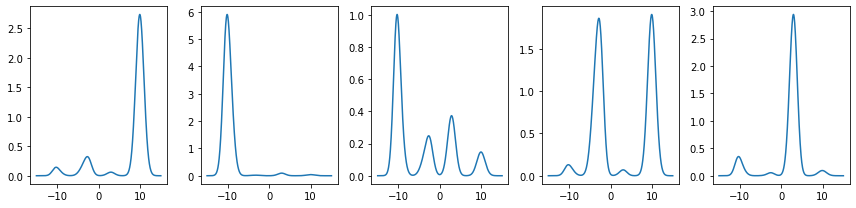

In [34]:
from scipy.integrate import trapz


fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(12,3))

q = opt_x_pen
latent_mass = []
means = []

for j in range(M.shape[0]):
    dens =  (q @ M * J @ component_dens)[j, :]
    axes[j].plot(xgrid, dens)
plt.tight_layout()

In [ ]:
x = opt_x_pen

curr_m = x @ M
trans_dens = curr_m @ component_dens * j
trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)
out = 0.0
for i in range(trans_dens.shape[0]):
    for j in range(i):
        curr = (np.sum((trans_dens[i, :] * trans_dens[j, :]) **2 ) * delta) 
        print(i, j, "{0:.5f}".format(curr))
        out += curr

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(12,3))


for j in range(M.shape[0]):
    axes[j].plot(xgrid, trans_dens[i, :])
plt.tight_layout()